In [12]:
import numpy as np
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

### HMM + Viterbi Class

In [13]:
class HMMViterbiNER:
    """
    Hidden Markov Model + Viterbi Algorithm for Named Entity Recognition.
    Supports tags: PER, LOC, ORG, O (others)
    """

    def __init__(self):
        self.states = []
        self.start_prob = {}
        self.trans_prob = {}
        self.emit_prob = {}
        self.vocab = set()

    def train(self, data):
        tag_counts = Counter()
        transitions = defaultdict(Counter)
        emissions = defaultdict(Counter)
        start_tags = Counter()

        for tokens, tags in data:
            start_tags[tags[0]] += 1
            for i, (w, t) in enumerate(zip(tokens, tags)):
                word = w.lower()
                tag_counts[t] += 1
                emissions[t][word] += 1
                self.vocab.add(word)

                if i > 0:
                    transitions[tags[i - 1]][t] += 1

        self.states = list(tag_counts.keys())
        S = len(self.states)

        # Start Probabilities
        total_start = sum(start_tags.values())
        self.start_prob = {t: (start_tags[t] + 1) / (total_start + S) for t in self.states}

        # Transition Probabilities
        self.trans_prob = {
            prev: {nxt: (transitions[prev][nxt] + 1) / (sum(transitions[prev].values()) + S)
                   for nxt in self.states}
            for prev in self.states
        }

        # Emission Probabilities
        V = len(self.vocab)
        self.emit_prob = {
            t: {w: (emissions[t][w] + 1) / (sum(emissions[t].values()) + V)
                for w in self.vocab}
            for t in self.states
        }

    def _emission(self, tag, word):
        word = word.lower()
        return self.emit_prob[tag].get(word, 1e-6)

    def viterbi(self, tokens):
        n = len(tokens)
        s = len(self.states)
        dp = np.full((s, n), -np.inf)
        back = np.zeros((s, n), dtype=int)

        # Initialization
        for i, st in enumerate(self.states):
            dp[i, 0] = np.log(self.start_prob[st]) + np.log(self._emission(st, tokens[0]))

        # Recursion
        for t in range(1, n):
            for i, st in enumerate(self.states):
                best = -np.inf
                best_prev = 0
                for j, prev in enumerate(self.states):
                    p = dp[j, t - 1] + np.log(self.trans_prob[prev][st]) + np.log(self._emission(st, tokens[t]))
                    if p > best:
                        best = p
                        best_prev = j
                dp[i, t] = best
                back[i, t] = best_prev

        # Backtracking
        best_last = np.argmax(dp[:, -1])
        path = [best_last]

        for t in range(n - 1, 0, -1):
            best_last = back[best_last, t]
            path.append(best_last)

        path.reverse()
        tags = [self.states[i] for i in path]

        # Confidence softmax
        confidences = []
        for t in range(n):
            col = dp[:, t]
            max_log = np.max(col)
            softmax = np.exp(col - max_log)
            probs = softmax / softmax.sum()
            confidences.append(float(probs[path[t]]))

        return tags, confidences

    def predict(self, text):
        tokens = text.split()
        tags, conf = self.viterbi(tokens)
        return list(zip(tokens, tags, conf))

    def extract_entities(self, text):
        preds = self.predict(text)
        result = defaultdict(list)

        current = []
        cur_tag = None

        for tok, tag, conf in preds:
            if tag == "O":
                if current:
                    result[cur_tag].append(" ".join(current))
                current = []
                cur_tag = None
            else:
                if tag == cur_tag:
                    current.append(tok)
                else:
                    if current:
                        result[cur_tag].append(" ".join(current))
                    current = [tok]
                    cur_tag = tag

        if current:
            result[cur_tag].append(" ".join(current))

        return dict(result)

In [14]:
training_data = [
    (["John", "lives", "in", "Paris"], ["PER", "O", "O", "LOC"]),
    (["Mary", "works", "at", "Google"], ["PER", "O", "O", "ORG"]),
    (["Steve", "Jobs", "founded", "Apple"], ["PER", "PER", "O", "ORG"]),
    (["Alice", "visited", "New", "York"], ["PER", "O", "LOC", "LOC"]),
    (["Amazon", "is", "in", "Seattle"], ["ORG", "O", "O", "LOC"]),
    (["Meta", "bought", "Instagram"], ["ORG", "O", "ORG"]),
    (["Jennifer", "moved", "to", "California"], ["PER", "O", "O", "LOC"]),
]

### Train the Model

In [15]:
model = HMMViterbiNER()
model.train(training_data)

print("✅ Model Trained Successfully")
print("States:", model.states)
print("Vocabulary Size:", len(model.vocab))

✅ Model Trained Successfully
States: ['PER', 'O', 'LOC', 'ORG']
Vocabulary Size: 26


In [16]:
def display_prediction(sentence):
    print("\nSentence:", sentence)

    preds = model.predict(sentence)
    table = [(tok, tag, f"{conf:.3f}") for tok, tag, conf in preds]

    print("\nPrediction Table:")
    print(tabulate(table, headers=["Token", "Tag", "Confidence"], tablefmt="github"))

    print("\nExtracted Entities:")
    print(model.extract_entities(sentence))

In [17]:
test_sentences = [
    "John met Mary in New York",
    "Google opened a new office in Paris",
    "Alice works at Amazon in Seattle",
    "Jennifer moved from California to Berlin",
    "Steve Jobs founded Apple in California"
]

for sentence in test_sentences:
    display_prediction(sentence)
    print("\n")


Sentence: John met Mary in New York

Prediction Table:
| Token   | Tag   |   Confidence |
|---------|-------|--------------|
| John    | PER   |        0.706 |
| met     | O     |        0.6   |
| Mary    | ORG   |        0.264 |
| in      | O     |        0.552 |
| New     | LOC   |        0.517 |
| York    | LOC   |        0.588 |

Extracted Entities:
{'PER': ['John'], 'ORG': ['Mary'], 'LOC': ['New York']}



Sentence: Google opened a new office in Paris

Prediction Table:
| Token   | Tag   |   Confidence |
|---------|-------|--------------|
| Google  | PER   |        0.426 |
| opened  | O     |        0.524 |
| a       | LOC   |        0.333 |
| new     | LOC   |        0.501 |
| office  | PER   |        0.2   |
| in      | O     |        0.487 |
| Paris   | LOC   |        0.507 |

Extracted Entities:
{'PER': ['Google', 'office'], 'LOC': ['a new', 'Paris']}



Sentence: Alice works at Amazon in Seattle

Prediction Table:
| Token   | Tag   |   Confidence |
|---------|-------|-------

### Emission Probabilitie Table

In [18]:
def show_emission_table(model):
    df = pd.DataFrame(
        {tag: {word: model.emit_prob[tag].get(word, 0.0) for word in model.vocab}
         for tag in model.states}
    ).T

    print("\nEmission Probability Matrix:")
    print(tabulate(df, headers="keys", tablefmt="github"))


show_emission_table(model)


Emission Probability Matrix:
|     |      john |     paris |   instagram |        to |   california |        in |      jobs |     moved |    amazon |     works |    google |     steve |    bought |     lives |   visited |     apple |   jennifer |        at |   founded |   seattle |      meta |       new |        is |      york |     alice |      mary |
|-----|-----------|-----------|-------------|-----------|--------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| PER | 0.0625    | 0.03125   |   0.03125   | 0.03125   |    0.03125   | 0.03125   | 0.0625    | 0.03125   | 0.03125   | 0.03125   | 0.03125   | 0.0625    | 0.03125   | 0.03125   | 0.03125   | 0.03125   |  0.0625    | 0.03125   | 0.03125   | 0.03125   | 0.03125   | 0.03125   | 0.03125   | 0.03125   | 0.0625    | 0.06

### Heatmap for Transition Probabilities

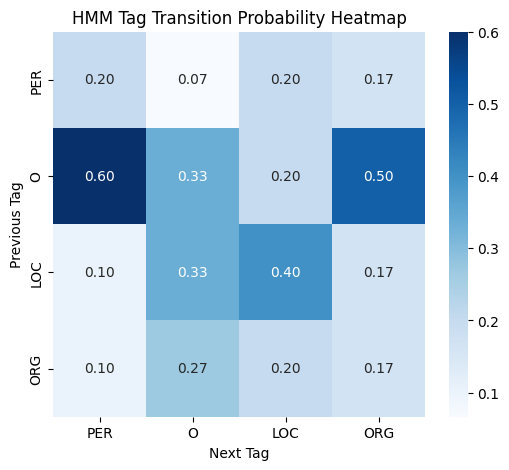

In [19]:
def plot_transition_heatmap(model):
    df = pd.DataFrame(model.trans_prob)
    df = df.reindex(index=model.states, columns=model.states)

    plt.figure(figsize=(6, 5))
    sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")
    plt.title("HMM Tag Transition Probability Heatmap")
    plt.xlabel("Next Tag")
    plt.ylabel("Previous Tag")
    plt.show()

plot_transition_heatmap(model)